In [5]:
import torch
from medmnist import ChestMNIST
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.metrics import hamming_loss, precision_recall_fscore_support, average_precision_score, accuracy_score

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = ChestMNIST(split="train", download=True,transform=transform)
val_data = ChestMNIST(split="val", download=True, transform=transform)
test_data = ChestMNIST(split="test", download=True, transform=transform)

print(f"lenght of train data: {len(train_data)}")
print(f"lenght of validation data: {len(val_data)}")
print(f"lenght of test data: {len(test_data)}")

100%|██████████| 82.8M/82.8M [02:14<00:00, 618kB/s]


lenght of train data: 78468
lenght of validation data: 11219
lenght of test data: 22433


In [7]:
train_loader = DataLoader(train_data, batch_size=64)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

x, y = next(iter(train_data))
print(f"train data shape x:{x.shape}")
print(f"train data shape y:{y.shape}")

train data shape x:torch.Size([1, 28, 28])
train data shape y:(14,)


In [8]:
def visualize(image, label):
    fig, axe = plt.subplots(3, 5, figsize=(20, 10))
    for i, ax in enumerate(axe.flatten()):
        ax.imshow(image[i].squeeze())
        ax.set_title(f"label:{torch.argmax(label[i])}")
        ax.axis("off")

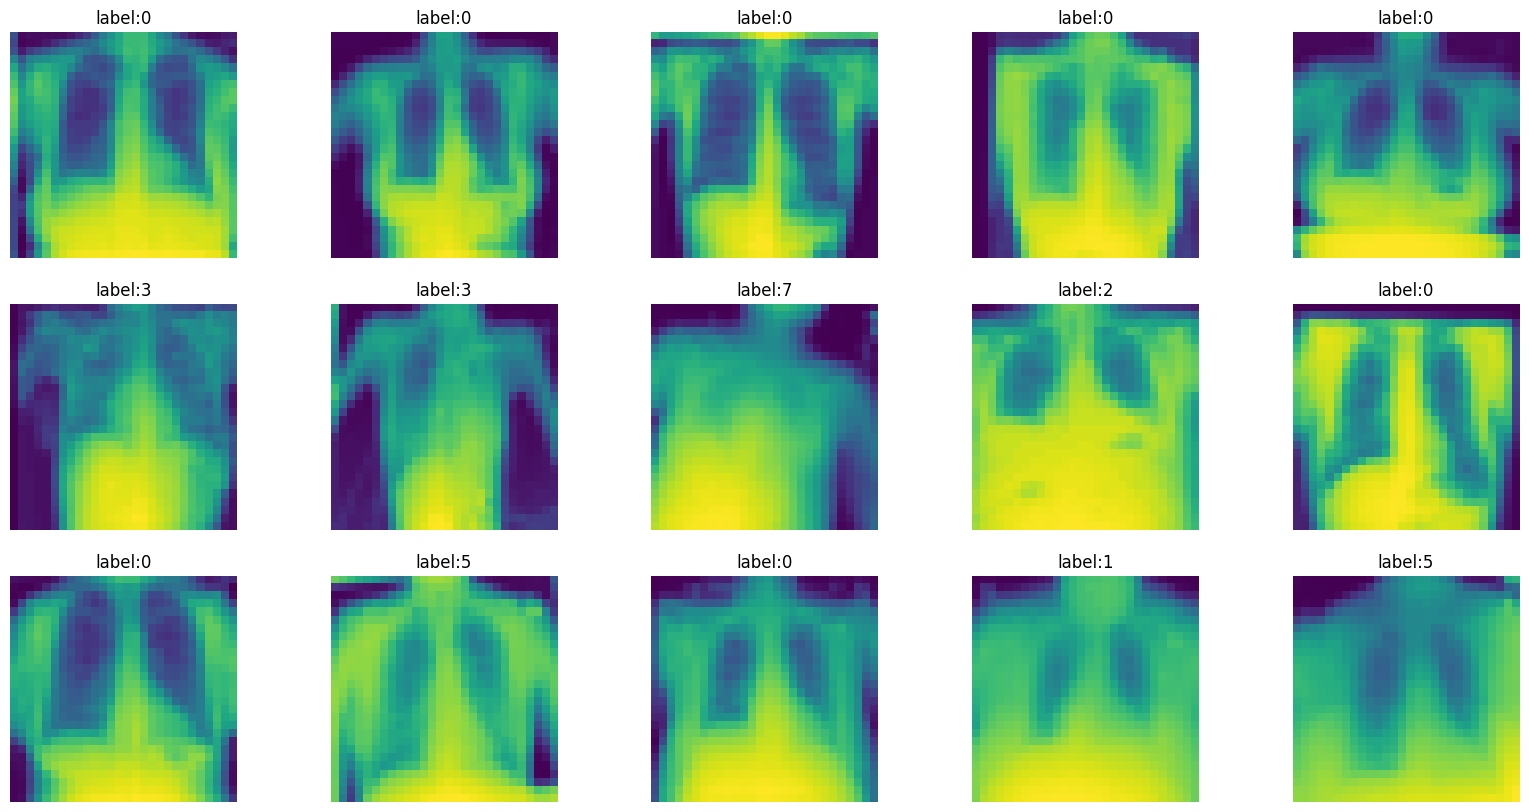

In [9]:
image, label = next(iter(train_loader))
visualize(image, label)

In [10]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
print(f"current device: {device}")

current device: cuda


In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        logit = self.model_stack(x)
        return logit


# chestmnist has 14 class and each image is 28*28
model = SimpleNN(28 * 28, 14).to(device)
print(model)


SimpleNN(
  (model_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=64, out_features=64, bias=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=64, out_features=14, bias=True)
  )
)


In [12]:
loss_nn = nn.BCEWithLogitsLoss()  # it is used for multi label classification.combines sigmoid and binary crossentropy
optimizer_nn = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
def train(dataloader, model, loss_nn, optimizer):
    model.train()
    total_loss = 0
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_nn(pred.float(), y.float())  # BCEWithLogitsLoss just accepts float type
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [14]:
def test(dataloader, model, loss_nn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_nn(pred.float(), y.float())
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [15]:
n_epochs = 20
train_loss_list = []
val_loss_list = []
for epoch in (pbar := trange(n_epochs)):
    train_loss = train(train_loader, model, loss_nn, optimizer_nn)
    val_loss = test(val_loader, model, loss_nn)
    pbar.set_description(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

Train loss: 0.1573, Val loss: 0.1691: 100%|██████████| 20/20 [06:09<00:00, 18.48s/it]


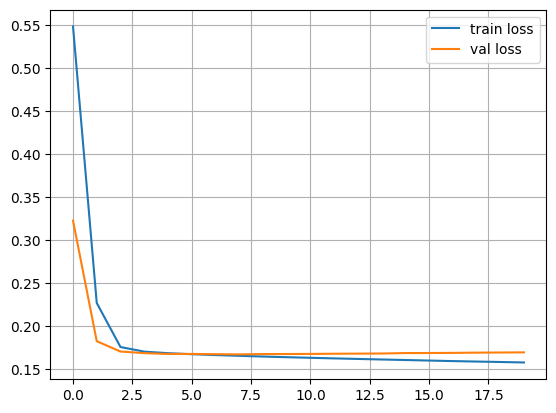

In [16]:
plt.plot(range(n_epochs), train_loss_list, label="train loss")
plt.plot(range(n_epochs), val_loss_list, label="val loss")
plt.legend()
plt.grid()
plt.show()

In [46]:
def evaluate_model(model, dataloader):
    model.eval()
    total_pred, total_label = [], []
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            pred = torch.sigmoid(pred) > 0.35
            pred=pred.cpu().numpy()
            y=y.cpu().numpy() # sklearn metrics just accept numpy and gpu doesnt accept numpy
            total_pred.extend(pred)
            total_label.extend(y)
    hamming = hamming_loss(pred, y)
    subset_acc = accuracy_score(pred, y)
    precision, recall, f1, _ = precision_recall_fscore_support(pred, y, average="macro")
    avg_precision = average_precision_score(pred, y, average="macro")

    print(f'Hamming Loss: {hamming:.4f}')
    print(f'Subset Accuracy: {subset_acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'Average Precision: {avg_precision:.4f}')
    return {
        'Hamming Loss': hamming,
        'Subset Accuracy': subset_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Average Precision': avg_precision
    }


In [47]:
metrics = evaluate_model(model, test_loader)

Hamming Loss: 0.0519
Subset Accuracy: 0.5152
Precision: 0.0548
Recall: 0.2143
F1-Score: 0.0810
Average Precision: 0.0548


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me